In [68]:
import requests
import json
import datetime
import numpy as np
import pandas as pd
import os

In [2]:
DIRECTORY = 'study_data'

# Download Data

In [3]:
# Manual stuff, maybe automate this somehow
ids = [
    '1babb9e7-f88b-489a-b82a-4b67e3f58d55',
    '1be9abef-6967-492a-9b83-46cb08493357',
    '284a0170-caed-4c29-bfac-757409b9d248',
    '5ba5e566-409a-4664-a9fa-f27c08422578',
    'd6962ede-e622-475e-959a-5405af68414b',
    'd91a3af6-1a81-48a4-a8c2-1eb6022401b6',
    'dfe18eb9-791b-440d-8e55-61b6886904b2',
    'ec110976-0192-436d-b451-4f5dd97e71d8',
    '21e6abea-ebbc-453b-8cff-15064e32db06',
    'd6b2d9b9-398b-4e0d-b52b-224747f515c8', # Me
]

# Media token
media_token = '4e842bb8-b660-42a3-b67b-d8f2223815d9'

# File name prefixes
ANSWERS  = 'answers'
POINTS   = 'points'
STOPS    = 'stops'
MOVES    = 'moves'
FEATURES = 'features'

In [4]:
# Make file names
def points_type(month, day, year=2020):
    return '%s-%i-%i-%i' % (POINTS, year, month, day) 

def make_file_name(user_id, file_type, month=-1, day=-1):
    if file_type == POINTS:
        return points_type(month, day) + '_' + user_id + '.json'
    return file_type + '_' + user_id + '.json'

In [5]:
# Make url from parameters
def make_url(user_id, file_type, month=-1, day=-1):
    return 'https://firebasestorage.googleapis.com/v0/b/mobilityfeatures.appspot.com/o/' \
    + user_id \
    + '%2F' \
    + make_file_name(user_id, file_type, month=month, day=day)\
    + '?alt=media&token=' + media_token

In [6]:
def get_contents(url, debug=False):
    data = []
    r = requests.get(url)
    if r.ok:
        for line in r.content.decode("utf-8").split('\n'):
            if line: # Check if empty string
                try:
                    j = json.loads(line)
                    data.append(j)
                except:
                    if debug: print('Error for line:', line)
    else:
        print('File doesnt exist!')
    return data

# Example download

In [7]:
uid = 'd6962ede-e622-475e-959a-5405af68414b'

features_url = make_url(uid, FEATURES)
answers_url  = make_url(uid, ANSWERS)

features_data = get_contents(features_url)
answers_data  = get_contents(answers_url)

# Load

## Answers

In [153]:
a = pd.DataFrame(answers_data)
a = a.sort_values(['datetime'])

# create 'date' column
datetimes = pd.to_datetime(a.datetime)
dates = [dt.date() for dt in datetimes]
a['date'] = dates

# group by date, only keep the latest
a = a.groupby(['date']).last()
a.datetime = pd.to_datetime(a.datetime)

In [154]:
f = pd.DataFrame(features_data)
datetimes = pd.to_datetime(f.date)

# Convert to datetime object
dates = [dt.date() for dt in datetimes]
f.date = dates

# Rename time stamp to date time and standardize it
f['datetime'] = pd.to_datetime(f.timestamp)
f = f.drop(['timestamp'], axis=1)

# Discard entries with no time stamp (for now)
f = f[f.datetime.notnull()]

# only keep the last row for each date
f = f.groupby(['date']).last()

In [155]:
a = a.reset_index()
f = f.reset_index()

# Find dates for which features were computed, and answers were given
dates = np.intersect1d(f.date, a.date)

# Filter out elements not on the selected dates
f = f[f.date.isin(dates)]
a = a[a.date.isin(dates)]

# Check that they now contain the same elements
assert (len(a) == len(f))

# Pre proc functions
* Flipping the routine scale in case it was misunderstood
* Correcting the time of entries, in case people filled it out during the night or early the next day (probably because they forgot!)

In [156]:
def flip_routine_scale(ans):
    ans = str(ans)
    d = {'1': '5', '2': '4', '3': '3', '4': '2', '5': '1'}
    return d[ans]

def check_routine_scale(answer_series, feature_series):
    assert(len(answer_series) == len(feature_series))
    
    ans  = pd.to_numeric(answer_series).values
    feat = pd.to_numeric(feature_series).values
    
    for i in range(len(answer_series)):
        if abs(ans[i] / 5 - feat[i]) > 0.9:
            ans[i] = str(flip_routine_scale(ans[i]))
    return np.array([str(a) for a in ans], dtype=object)

In [157]:
def correct_dates(dt):
    if 0 <= dt.hour and dt.hour <= 12: 
        # sets time to midnight and subtracts 1 second to go to prev date
        new_dt = dt.normalize() + pd.Timedelta(seconds=-1) 
        return new_dt
    return dt

In [158]:
a.routine_scale = a.routine_scale.apply(flip_routine_scale)
a.routine_scale = check_routine_scale(a.routine_scale, f.routine_overlap_today)

# Download answers and features Data

In [146]:
answers  = {}
features = {}

for uid in ids:
    print('Downloading for %s ...' % uid)
    features_url = make_url(uid, FEATURES)
    answers_url  = make_url(uid, ANSWERS)

    features_data = get_contents(features_url)
    answers_data  = get_contents(answers_url)
    
    a = pd.DataFrame(answers_data)
    f = pd.DataFrame(features_data)
    
    answers[uid]  = a
    features[uid] = f

# Preprocessing 1
* Convert to date and datetime objects such that queries can be made on these.

In [163]:
for uid in ids:    
    #### Answers ####
    a = answers[uid]
    a = a.sort_values(['datetime'])

    # Convert datetime column into datetime objects
    datetimes = pd.to_datetime(a.datetime)
    a.datetime = datetimes
    
    # Correct datetime of entries
    a.datetime = a.datetime.apply(correct_dates)
    
    # Make a date column to easily select by date later on
    dates = [dt.date() for dt in datetimes]
    a['date'] = dates
    
    #### Features ####
    f = features[uid]
    datetimes = pd.to_datetime(f.date)

    # Convert to datetime object
    dates = [dt.date() for dt in datetimes]
    f.date = dates

    # Rename time stamp to date time and standardize it
    f['datetime'] = pd.to_datetime(f.timestamp)
    f = f.drop(['timestamp'], axis=1)
    
    # group by date, only keep the latest
    a = a.groupby(['date']).last()

    # Discard entries with no time stamp (for now)
    f = f[f.datetime.notnull()]
    # only keep the last row for each date
    f = f.groupby(['date']).last()
    
    answers[uid] = a
    features[uid] = f
print('Finished.')

Finished.


# Get total number of answer dates, used for plotting

In [169]:
num_answer_dates = {}
for uid in ids:
    num_answer_dates[uid] = [len(answers[uid])]

In [170]:
df = pd.DataFrame.from_dict(num_answer_dates).T
df.columns = ['num_days_answered']
df.index = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'R']
df

,num_days_answered
P1,17
P2,14
P3,15
P4,14
P5,13
P6,17
P7,14
P8,13
P9,4
R,21


In [171]:
df.to_csv('%s/num_days_answered.csv' % (DIRECTORY))

# Step 2, remove dates where they dont intersect

In [167]:
for uid in ids:    
    a = answers[uid]
    f = features[uid]
    #### Dates ####
    # Find dates for which features were computed, and answers were given
    a = a.reset_index()
    f = f.reset_index()
    dates = np.intersect1d(f.date, a.date)

    # Filter out elements not on the selected dates
    f = f[f.date.isin(dates)]
    a = a[a.date.isin(dates)]

    # Check that they now contain the same elements
    assert (len(a) == len(f))

    # Certain participants misunderstood the routine scale
    # This needs to be corrected by inverting the scale on certain days.
    if uid == 'ec110976-0192-436d-b451-4f5dd97e71d8':
        a.routine_scale = a.routine_scale.apply(flip_routine_scale)
        # Flips exteme outliers
        a.routine_scale = check_routine_scale(a.routine_scale, f.routine_overlap_today)
    
    a.to_csv('%s/answers_%s.csv' % (DIRECTORY,uid))
    f.to_csv('%s/features_%s.csv' % (DIRECTORY,uid))
    
    answers[uid] = a
    features[uid] = f

# Download raw points

In [8]:
def get_points_data(uid):
    # Start date april 22nd
    m = 4
    d = 22

    points_data = []

    for i in range(30):
        if d > 30:
            d = 1
            m += 1
        else:
            d += 1

        p = get_contents(make_url(uid, POINTS, m, d))
        if p != []:
            points_data.append(p)
    return points_data

In [ ]:
points = {}

for uid in ids:
    print(uid)
    points[uid] = get_points_data(uid)

print('Finished!')

In [76]:
bytes_per_point = 100

In [118]:
storage_data = {}

for uid in ids:
    s = 0
    for pp in points[uid]:
        s += len(pp)
    
    n = len(points[uid])
    mb = s * bytes_per_point/(1024 * 1024)
    
    storage_data[uid] = [n, s, mb]
    
    print(uid, '\tdays:', n, '\tpoints (k): ', int(s/1000), '\tSize (MB): %.2f' % mb, '\tavg:', int(s/n), 'points per day', int(1024 * mb/n), 'KB per day', )

1babb9e7-f88b-489a-b82a-4b67e3f58d55 	days: 23 	points (k):  181 	Size (MB): 17.28 	avg: 7878 points per day 769 KB per day
1be9abef-6967-492a-9b83-46cb08493357 	days: 25 	points (k):  142 	Size (MB): 13.55 	avg: 5684 points per day 555 KB per day
284a0170-caed-4c29-bfac-757409b9d248 	days: 21 	points (k):  101 	Size (MB): 9.71 	avg: 4850 points per day 473 KB per day
5ba5e566-409a-4664-a9fa-f27c08422578 	days: 22 	points (k):  98 	Size (MB): 9.43 	avg: 4494 points per day 438 KB per day
d6962ede-e622-475e-959a-5405af68414b 	days: 14 	points (k):  209 	Size (MB): 20.00 	avg: 14977 points per day 1462 KB per day
d91a3af6-1a81-48a4-a8c2-1eb6022401b6 	days: 26 	points (k):  101 	Size (MB): 9.73 	avg: 3922 points per day 383 KB per day
dfe18eb9-791b-440d-8e55-61b6886904b2 	days: 23 	points (k):  1116 	Size (MB): 106.44 	avg: 48525 points per day 4738 KB per day
ec110976-0192-436d-b451-4f5dd97e71d8 	days: 15 	points (k):  141 	Size (MB): 13.47 	avg: 9417 points per day 919 KB per day
21e6ab

In [122]:
df = pd.DataFrame.from_dict(storage_data).T
df.columns = ['num_of_days', 'num_points', 'size_mb']
df.index = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'R']
df

,num_of_days,num_points,size_mb
P1,23.0,181213.0,17.281818
P2,25.0,142109.0,13.552570
P3,21.0,101865.0,9.714603
P4,22.0,98887.0,9.430599
P5,14.0,209683.0,19.996929
P6,26.0,101994.0,9.726906
P7,23.0,1116075.0,106.437206
P8,15.0,141260.0,13.471603
P9,12.0,51740.0,4.934311
R,24.0,365606.0,34.866905


In [123]:
df.to_csv('%s/storage_points.csv' % (DIRECTORY))

In [135]:
stops = {}
for uid in ids:
    stops[uid] = get_contents(make_url(uid, STOPS))
print('finished!')

finished!


In [138]:
len(stops[uid])

234

In [129]:
bytes_per_stop = int(32332 / 234) + 1
bytes_per_stop

139

In [141]:
stops_storage_data = {}

for uid in ids:
    print(uid)
    num_stops = len(stops[uid])
    mb = num_stops * bytes_per_stop/(1024 * 1024)
    print(num_stops, mb)
    stops_storage_data[uid] = [num_stops, mb]

1babb9e7-f88b-489a-b82a-4b67e3f58d55
90 0.011930465698242188
1be9abef-6967-492a-9b83-46cb08493357
13 0.0017232894897460938
284a0170-caed-4c29-bfac-757409b9d248
2089 0.2769193649291992
5ba5e566-409a-4664-a9fa-f27c08422578
2922 0.3873424530029297
d6962ede-e622-475e-959a-5405af68414b
99 0.013123512268066406
d91a3af6-1a81-48a4-a8c2-1eb6022401b6
43 0.005700111389160156
dfe18eb9-791b-440d-8e55-61b6886904b2
41 0.005434989929199219
ec110976-0192-436d-b451-4f5dd97e71d8
2423 0.3211946487426758
21e6abea-ebbc-453b-8cff-15064e32db06
50 0.0066280364990234375
d6b2d9b9-398b-4e0d-b52b-224747f515c8
234 0.031019210815429688


In [143]:
df = pd.DataFrame.from_dict(stops_storage_data).T
df.columns = ['num_stops', 'size_mb']
df.index = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'R']
df

,num_stops,size_mb
P1,90.0,0.011930
P2,13.0,0.001723
P3,2089.0,0.276919
P4,2922.0,0.387342
P5,99.0,0.013124
P6,43.0,0.005700
P7,41.0,0.005435
P8,2423.0,0.321195
P9,50.0,0.006628
R,234.0,0.031019


In [144]:
df.to_csv('%s/storage_stops.csv' % (DIRECTORY))

# Corrections

In [44]:
df = pd.read_csv('study_data/storage_points.csv')
df['avg_points_per_day'] = df.num_points / df.num_days
df['avg_size_per_day'] = df.size_mb / df.num_days
df = df.round(1)
df

,Unnamed: 0,num_days,num_points,size_mb,avg_points_per_day,avg_size_per_day
0,P1,23.0,181213.0,17.3,7878.8,0.8
1,P2,25.0,142109.0,13.6,5684.4,0.5
2,P3,21.0,101865.0,9.7,4850.7,0.5
3,P4,22.0,98887.0,9.4,4494.9,0.4
4,P5,14.0,209683.0,20.0,14977.4,1.4
5,P6,26.0,101994.0,9.7,3922.8,0.4
6,P7,23.0,1116075.0,106.4,48525.0,4.6
7,P8,15.0,141260.0,13.5,9417.3,0.9
8,P9,12.0,51740.0,4.9,4311.7,0.4
9,R,24.0,365606.0,34.9,15233.6,1.5


In [42]:
df.to_csv('%s/storage_points.csv' % (DIRECTORY))

# Show gaps in the data

In [396]:
uid = 'd6b2d9b9-398b-4e0d-b52b-224747f515c8' # me
#uid = 'ec110976-0192-436d-b451-4f5dd97e71d8' # diligent participant
#uid = 'dfe18eb9-791b-440d-8e55-61b6886904b2' # participant with many points

In [397]:
points[uid] = get_points_data(uid)

File doesnt exist!
File doesnt exist!
File doesnt exist!
File doesnt exist!
File doesnt exist!


In [398]:
s = 0
for x in points[uid]:
    for y in x:
        s += len(y)
print('Total number of points:', s)

Total number of points: 731212


In [399]:
# Get datetimes
datetimes = []
for day in points[uid]:
    P = []
    
    # Extract datetimes as float
    for p in day: P.append(p['datetime'])
    
    # Convert to datetime objects series
    dt = pd.to_datetime(P, unit='ms') + pd.Timedelta('02:00:00')
    datetimes.append(dt)

# Get dates
dates = []
for x in datetimes:
    for y in x:
        dates.append(y.normalize())
dates = sorted(list(set(dates)))

In [400]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Hour formatting
hours = mdates.HourLocator(interval = 1)
h_fmt = mdates.DateFormatter('%H')

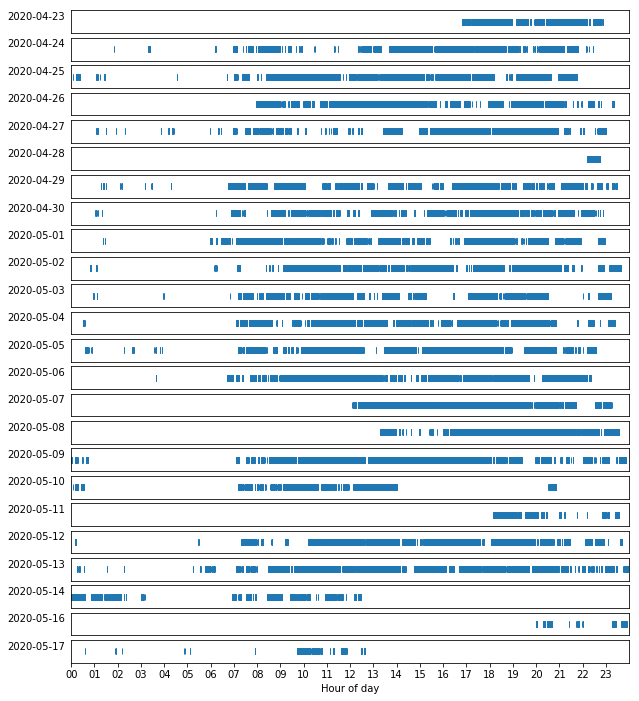

In [401]:
height = 0.5
n = len(datetimes)
fig, ax = plt.subplots(n, 1, figsize=[10, n*height])

for day in range(n):
    N = len(datetimes[day])
    min_time = dates[day]
    max_time = dates[day].replace(hour=23, minute=59, second=59)
    
    ax[day].plot(datetimes[day], np.zeros(N), '|')
    ax[day].set_yticks([])
    ax[day].set_xlim([min_time, max_time])
    ax[day].set_ylabel(str(dates[day])[:10], rotation=0, labelpad=35)

    if day == n-1:

        ax[day].xaxis.set_major_locator(hours)
        ax[day].xaxis.set_major_formatter(h_fmt)
        ax[day].set_xlabel('Hour of day',)
    else:
        ax[day].set_xticks([])
    
    
    plt.savefig('plots/%s-gaps' % uid, dpi=300)

In [363]:
stops = {}
uid = 'd6b2d9b9-398b-4e0d-b52b-224747f515c8'
stops[uid] = get_contents(make_url(uid, STOPS))

In [364]:
# Get datetimes
stops_parsed = []
for s in stops[uid]:    
    x = {}
    x['arrival'] = pd.to_datetime(s['arrival'], unit='ms')
    x['departure'] = pd.to_datetime(s['departure'], unit='ms')
    x['place_id'] = int(s['place_id'])
    
    # Convert to datetime objects series
    stops_parsed.append(x)

In [365]:
def normalize(x): return x.normalize()

In [366]:
stops_df = pd.DataFrame(stops_parsed, columns=['arrival', 'departure', 'place_id'])
stops_df['date'] = stops_df.arrival.apply(normalize)

In [367]:
stops_df.date.min()

Timestamp('2020-05-04 00:00:00')

In [368]:
stops_df.date.max()

Timestamp('2020-05-17 00:00:00')

0
0
0
0
0
0
0
0
0
0
0
1
25
35
27
24
42
11
6
20
35
3
0


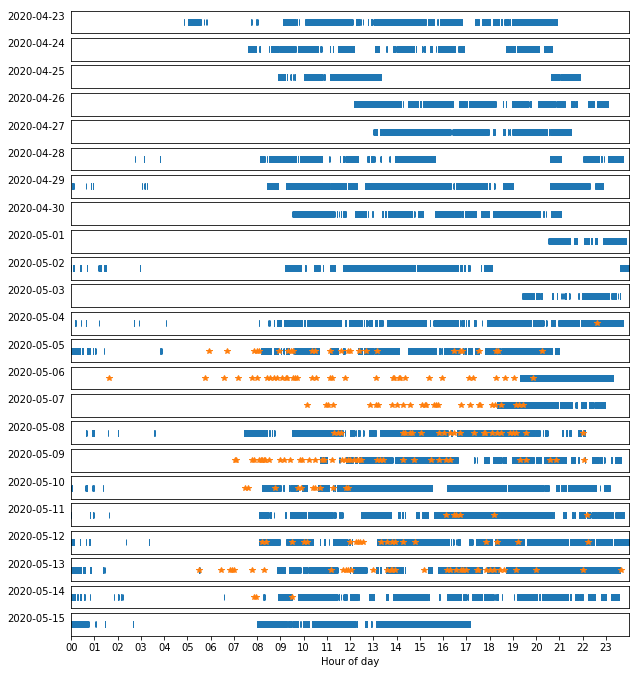

In [370]:
height = 0.5
n = len(datetimes)
fig, ax = plt.subplots(n, 1, figsize=[10, n*height])

for day in range(n):
    N = len(datetimes[day])
    min_time = dates[day]
    max_time = dates[day].replace(hour=23, minute=59, second=59)
    
    stops_today = stops_df[stops_df.date == min_time]
    n_stops = len(stops_today)
    print(n_stops)
    ax[day].plot(datetimes[day], np.zeros(N), '|')
    ax[day].plot(stops_today.arrival, np.zeros(n_stops), '*')
    ax[day].set_yticks([])
    ax[day].set_xlim([min_time, max_time])
    ax[day].set_ylabel(str(dates[day])[:10], rotation=0, labelpad=35)

    if day == n-1:
        ax[day].xaxis.set_major_locator(hours)
        ax[day].xaxis.set_major_formatter(h_fmt)
        ax[day].set_xlabel('Hour of day',)
    else:
        ax[day].set_xticks([])
    
    
    #plt.savefig('plots/%s-gaps' % uid, dpi=300)

In [393]:
f = get_contents(features_url)
f = pd.DataFrame(f)
f.timestamp = pd.to_datetime(f.timestamp)
f.date = pd.to_datetime(f.date)
f.timestamp = f.timestamp + pd.DateOffset(hours=2)

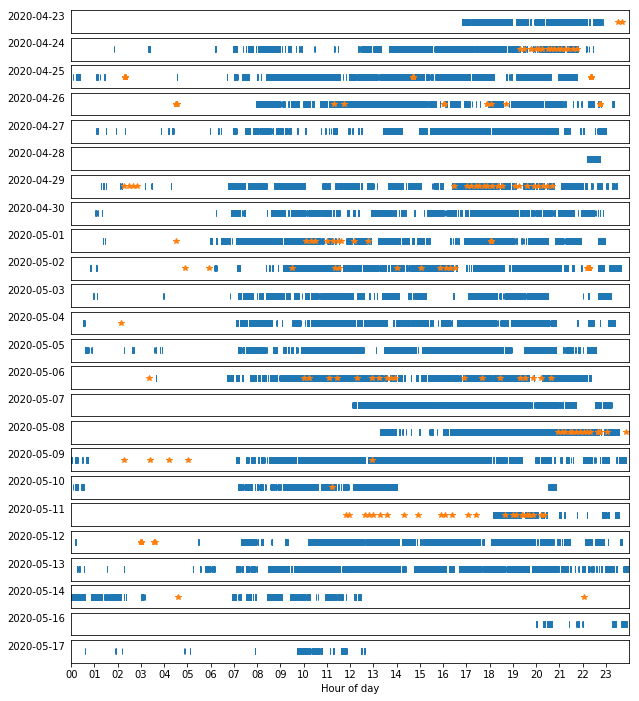

In [402]:
height = 0.5
n = len(datetimes)
fig, ax = plt.subplots(n, 1, figsize=[10, n*height])

for day in range(n):
    N = len(datetimes[day])
    min_time = dates[day]
    max_time = dates[day].replace(hour=23, minute=59, second=59)
    
    f_today = f[f.date == min_time]
    ax[day].plot(datetimes[day], np.zeros(N), '|')
    ax[day].plot(f_today.timestamp, np.zeros(len(f_today)), '*')
    ax[day].set_yticks([])
    ax[day].set_xlim([min_time, max_time])
    ax[day].set_ylabel(str(dates[day])[:10], rotation=0, labelpad=35)

    if day == n-1:
        ax[day].xaxis.set_major_locator(hours)
        ax[day].xaxis.set_major_formatter(h_fmt)
        ax[day].set_xlabel('Hour of day',)
    else:
        ax[day].set_xticks([])
    
    
    #plt.savefig('plots/%s-gaps' % uid, dpi=300)